# Installing Apache Beam 

In [56]:
#!{pip install --quiet apache-beam}
!pip install -q -U \
  tensorflow==2.0.0 \
  apache-beam

In [57]:
import tensorflow as tf
import apache_beam as beam


In [58]:
print('TensorFlow version: {}'.format(tf.__version__))
print('Beam version: {}'.format(beam.__version__))

TensorFlow version: 2.0.0
Beam version: 2.41.0


In [59]:
from apache_beam.transforms.util import Create
pipeline1 = beam.Pipeline()

example = (pipeline1
           |"Create">>beam.Create(['Initiating Apache Beam...', 'Example 1', 'Try'])
)
           
example | beam.Map(print)
result = pipeline1.run()
result.state

Initiating Apache Beam...
Example 1
Try


'DONE'

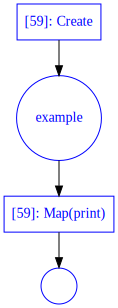

In [60]:
from apache_beam.runners.interactive.display import pipeline_graph
import graphviz
def display_pipeline(pipeline):
  graph = pipeline_graph.PipelineGraph(pipeline)
  return graphviz.Source(graph.get_dot())

display_pipeline(pipeline1)

True
False
True
False
True
False
True
False
True


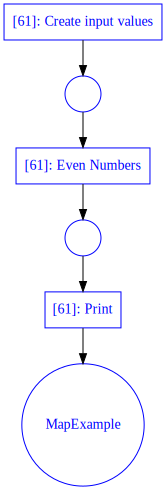

In [61]:
input = [0,1,2,3,4,5,6,7,8]
with beam.Pipeline() as pipelineMap:
  MapExample = (
    pipelineMap
    |"Create input values">> beam.Create(input)
    |"Even Numbers">> beam.Map(lambda x:x%2==0)
    |"Print">> beam.Map(print)
)
display_pipeline(pipelineMap)

1
2
2
3
3
3
4
4
4
4


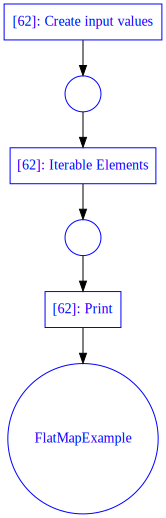

In [62]:
input = [1,2,3,4]
with beam.Pipeline() as pipelineFlatMap:
  FlatMapExample = (
    pipelineFlatMap
    |"Create input values">> beam.Create(input)
    |"Iterable Elements">> beam.FlatMap(lambda x: [x for i in range(x)])
    |"Print">> beam.Map(print)
)
# FlatMapExample | beam.Map(print)
# result1 = pipelineFlatMap.run()
# result.state
display_pipeline(pipelineFlatMap)

0
2
4
6
8


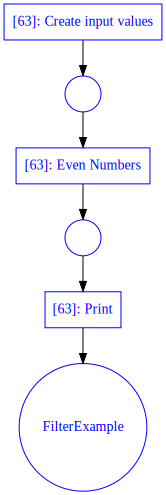

In [63]:
input = [0,1,2,3,4,5,6,7,8]
with beam.Pipeline() as pipelineFilter:
  FilterExample = (
    pipelineFilter
    |"Create input values">> beam.Create(input)
    |"Even Numbers">> beam.Filter(lambda x:x%2==0)
    |"Print">> beam.Map(print)
)
display_pipeline(pipelineFilter)

10
20
30
40
50
60
70
80
90
100


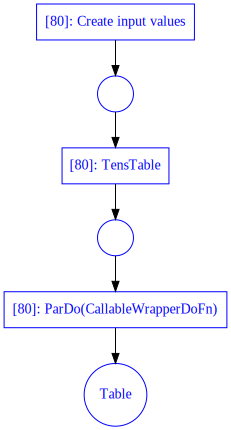

In [80]:
#input = [0,1,2,3,4,5,6,7,8,9,10]
class TensTable(beam.PTransform):
  def expand(self, pcollection):
    return(pcollection
      | beam.FlatMap(lambda line:line.split(","))
      | beam.Map(lambda num: int(num)*10)
    )
  


with beam.Pipeline() as pipeline2:
  Table = (pipeline2
            | "Create input values">> beam.Create(['1,2,3,4,5', '6,7,8,9,10'])
            | TensTable()
            | beam.ParDo(print))
display_pipeline(pipeline2)

In [140]:
class CustomTransform(beam.PTransform):
  
  def expand(self, input_coll):
    
    a = ( 
        input_coll
                       | 'Group and sum' >> beam.CombinePerKey(sum)
                       | 'filter' >> beam.Filter(filter_on_count)
                       | 'Survivors' >> beam.Map(format_output)
              
    )
    return a

def SplitRow(element):
    return element.split(',')
  
  
def filter_on_count(element):
  name, count = element
  if count > 1:
    return element
  
def format_output(element):
  name, count = element
  return ', '.join((name,str(count),'Regular'))

p = beam.Pipeline()

input_collection = ( 
                      p 
                      | "Read from csv file" >> beam.dataframe.io.read_csv('/content/training_titanic.csv')
                      | "Split rows" >> beam.Map(SplitRow)
                   )

male_count = (
                      input_collection
                      | 'Male Survivor' >> beam.Filter(lambda record: record[4] == 'male')
                      | 'Survived' >> beam.Map(lambda record: (" Male Survived:, " +record[1], 1))
                      | 'composite transform' >> CustomTransform()
                      | 'Write results for male survived' >> beam.io.WriteToText('maleSurvived_output.txt')
                 )

female_count = (
                      input_collection
                      | 'Female Survivor' >> beam.Filter(lambda record: record[4] == 'female')
                      | 'Survived' >> beam.Map(lambda record: (" Female Survived:, " +record[1], 1))
                      | 'composite transform' >> CustomTransform()
                      | 'Write results for female survived' >> beam.io.WriteToText('femaleSurvived_output.txt')
                 )

p.run()

